In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter


from sklearn import svm
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [6]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en_core_web_sm')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [7]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


In [8]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [9]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500


,cease,eleventh,France,correspondent,ride,Somersetshire,neat,flavour,wine,blade,...,tunnel,enjoy,Edward,vain,pair,black,evidence,satisfied,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


## Random Forest Model

In [11]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9673144876325088

Test set score: 0.8414310954063604


In [13]:
from sklearn.model_selection import cross_val_score
rfc_score = (cross_val_score(rfc, X, Y, cv=5))
print(rfc_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (rfc_score.mean(), rfc_score.std() * 2))

[0.82524272 0.78640777 0.84363958 0.83642794 0.82581786]
RFC Model Accuracy: 0.8235 (+/- 0.0396)


In [14]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

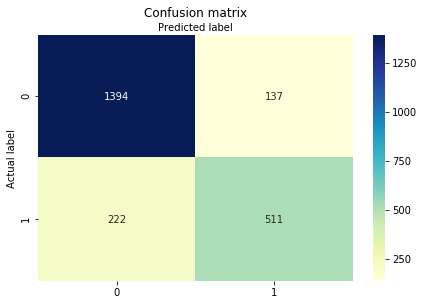

In [16]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Logistic Regression Model

In [18]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.9337455830388692

Test set score: 0.8652826855123675


In [19]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.84907326 0.81641659 0.87014134 0.86825818 0.85411141]
LR Model Accuracy: 0.8516 (+/- 0.0387)


In [20]:
y_pred = lr.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

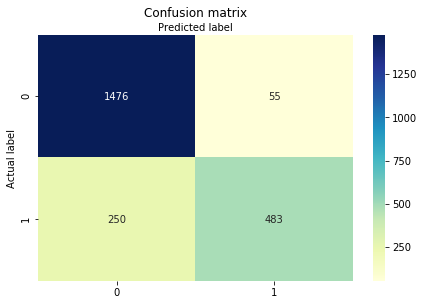

In [22]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Gradient Boosting Model

In [23]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.835394581861013

Test set score: 0.818904593639576


In [24]:
clf_score = (cross_val_score(clf, X, Y, cv=5))
print(lr_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (clf_score.mean(), clf_score.std() * 2))

[0.84907326 0.81641659 0.87014134 0.86825818 0.85411141]
LR Model Accuracy: 0.8055 (+/- 0.0579)


In [25]:
y_pred = lr.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

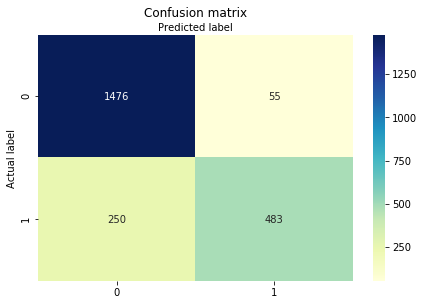

In [26]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Support Vector Machine Model

In [27]:
from sklearn.svm import SVC
svc = SVC()
train = svc.fit(X_train, y_train)

print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training set score: 0.6719670200235571

Test set score: 0.6762367491166078


In [28]:
svc_score = (cross_val_score(svc, X, Y, cv=5))
print(svc_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (svc_score.mean(), svc_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[0.67343336 0.67343336 0.67402827 0.67374005 0.67374005]
LR Model Accuracy: 0.6737 (+/- 0.0004)


In [30]:
y_pred = svc.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

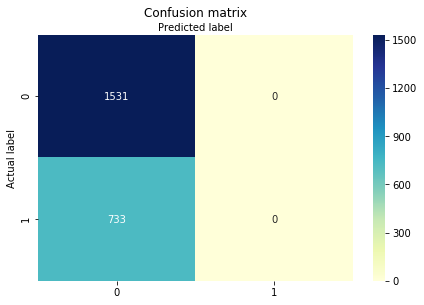

In [31]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Additional Features

In [29]:
# Creating copy of word_counts data frame to maintain integrity of original
word_counts2 = word_counts

# Adding in column for the number of words in each sentence
word_counts2['sent_length'] = word_counts2.text_sentence.map(lambda x: len(x))

# Creating list of number of adverbs in each sentence
sentences2 = word_counts2.text_sentence
adv_count = []
for sent in sentences2:
    advs = 0
    for token in sent:
        if token.pos_ == 'ADV':
            advs +=1
    adv_count.append(advs)

# Creating column for number of adverbs per sentence
word_counts2['adv_count'] = adv_count

# Creating list of number of verbs in each sentence
verb_count = []
for sent in sentences2:
    verb = 0
    for token in sent:
        if token.pos_ == 'VERB':
            verb +=1
    verb_count.append(verb)

word_counts2['verb_count'] = verb_count

# Creating list of number of nouns in each sentence
noun_count = []
for sent in sentences2:
    noun = 0
    for token in sent:
        if token.pos_ == 'NOUN':
            noun +=1
    noun_count.append(noun)

word_counts2['noun_count'] = noun_count


# Creating list of number of punctuation marks in each sentence
punc_count = []
for sent in sentences2:
    punc = 0
    for token in sent:
        if token.pos_ == 'PUNCT':
            punc +=1
    punc_count.append(punc)

word_counts2['punc_count'] = punc_count
word_counts2['next_sent_length'] = word_counts2['sent_length'].shift(-1)
word_counts2['prev_sent_length'] = word_counts2['sent_length'].shift(1)

# Inspecting new word counts 
word_counts2.head()

,cease,eleventh,France,correspondent,ride,Somersetshire,neat,flavour,wine,blade,...,satisfied,text_sentence,text_source,sent_length,adv_count,verb_count,noun_count,punc_count,next_sent_length,prev_sent_length
0,0,0,0,0,0,0,0,0,0,0,...,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,67,3,6,10,10,63.0,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,"(So, she, was, considering, in, her, own, mind...",Carroll,63,7,7,8,7,33.0,67.0
2,0,0,0,0,0,0,0,0,0,0,...,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,33,5,3,2,4,3.0,63.0
3,0,0,0,0,0,0,0,0,0,0,...,0,"(Oh, dear, !)",Carroll,3,0,0,0,1,6.0,33.0
4,0,0,0,0,0,0,0,0,0,0,...,0,"(I, shall, be, late, !, ')",Carroll,6,0,0,0,2,97.0,3.0


In [32]:
word_counts2 = word_counts2.dropna()

## Random Forest Model

In [65]:
Y = word_counts2['text_source']
X = np.array(word_counts2.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9893930465527401

Test set score: 0.8321554770318021


In [34]:
rfc_score = (cross_val_score(rfc, X, Y, cv=5))
print(rfc_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (rfc_score.mean(), rfc_score.std() * 2))

[0.77846425 0.77738516 0.84350133 0.83377542 0.83908046]
RFC Model Accuracy: 0.8144 (+/- 0.0600)


In [35]:
y_pred = rfc.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

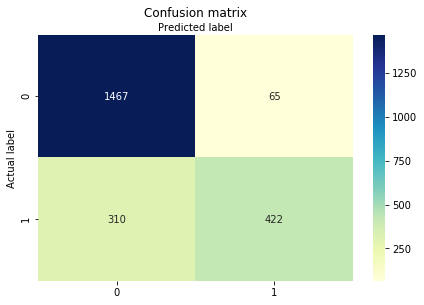

In [36]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Logistic Regression Model

In [64]:
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.940777843252799

Test set score: 0.8909010600706714


In [38]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.84377758 0.82155477 0.88505747 0.86206897 0.86472149]
RFC Model Accuracy: 0.8554 (+/- 0.0428)


In [40]:
y_pred = lr.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

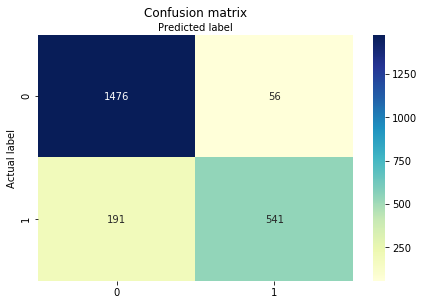

In [41]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Gradient Boosting Model

In [42]:
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.8411903358868592

Test set score: 0.8462897526501767


In [ ]:
clf_score = (cross_val_score(clf, X, Y, cv=5))
print(clf_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (clf_score.mean(), clf_score.std() * 2))

In [ ]:
y_pred = clf.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## Support Vector Machine

In [ ]:
train = svc.fit(X_train, y_train)

print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

In [ ]:
svc_score = (cross_val_score(svc, X, Y, cv=5))
print(svc_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (svc_score.mean(), svc_score.std() * 2))

In [ ]:
y_pred = svc.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

In [53]:
#Try optimizing the LR model
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'penalty': ['l1', 'l2'],
                     'class_weight': ['balanced', None],
                     'C': [0.1, 1 ,10, 100, 1000],
                    }]
 
gscv = GridSearchCV(estimator = LogisticRegression(), param_grid = tuned_parameters, cv = 5, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_params_

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1, 'class_weight': None, 'penalty': 'l2'}

These parameters are the default parameters we got before

## Adding another Book to the DataFrame

In [70]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [59]:
#Load in and clean a new book, using our text_cleaner function and the spacy load function
stories = gutenberg.raw('bryant-stories.txt')
stories = text_cleaner(stories)

#Spacy load
stories_doc = nlp(stories)

In [60]:
#Extract and store sentences from spacy doc
stories_sents = [[sent, 'bryant'] for sent in stories_doc.sents]

#Add the paradise sentences to our existing sentences DF
sentences = pd.DataFrame(alice_sents + persuasion_sents + stories_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


In [61]:
# Set up the bag of words for paradise.
storieswords = bag_of_words(stories_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords + storieswords)

In [62]:
word_counts3 = bow_features(sentences, common_words)
word_counts3.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500


,cease,eleventh,France,stately,correspondent,ride,Somersetshire,neat,weary,flavour,...,enjoy,Edward,vain,pair,black,evidence,satisfied,splendid,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


## Carrol vs. Austin vs. Bryant

In [66]:
Y = word_counts3['text_source']
X = np.array(word_counts3.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)

train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.9091616417039486

Test set score: 0.80950991831972


In [67]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

[0.75451895 0.69970845 0.77187865 0.76590776 0.72838785]
RFC Model Accuracy: 0.7441 (+/- 0.0535)


In [68]:
y_pred = lr.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

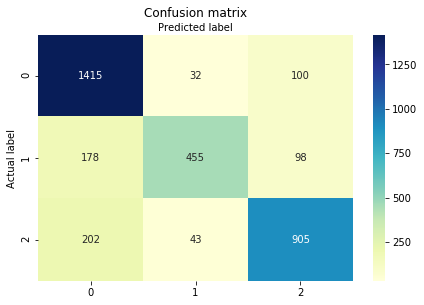

In [69]:
class_names=['Carroll', 'Austin'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 